Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 2624


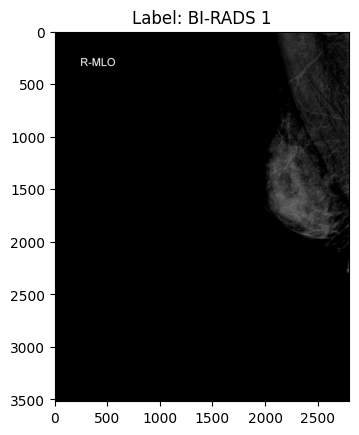

In [12]:
import os
import pydicom
import numpy as np
import cv2
import pandas as pd
import torch
from albumentations import Compose, Normalize
from pydicom.pixel_data_handlers.util import apply_voi_lut
from torch.utils.data import DataLoader, Dataset
import timm
from torchvision import transforms
import utils

# Ruta al dataset y al archivo CSV de anotaciones
dataset_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido'
annotations_csv_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido/metacomprimida.csv'

# Clase para cargar y preprocesar las imágenes DICOM
class MammoDataset(Dataset):
    def __init__(self, annotations_csv, dataset_path, transform=None):
        # Inicializa la clase MammoDataset, cargando las anotaciones desde un archivo CSV
        # y almacenando la ruta del dataset. También acepta una función de transformación opcional.
        self.annotations = pd.read_csv(annotations_csv)
        self.dataset_path = dataset_path
        self.transform = transform

    def __len__(self):
        # Devuelve el número total de anotaciones, lo que representa la cantidad de imágenes en el dataset.
        return len(self.annotations)

    def __getitem__(self, idx):
        # Carga una imagen y su etiqueta correspondiente basándose en el índice proporcionado.
        
        # Obtiene el series_id y image_id del archivo CSV en la fila correspondiente al índice.
        series_id = self.annotations.iloc[idx]['study_id_x']
        image_id = self.annotations.iloc[idx]['image_id']
        
        # Construye la ruta completa al archivo DICOM utilizando los identificadores obtenidos.
        dicom_path = os.path.join(self.dataset_path, series_id, f'{image_id}.dicom')
        
        # Lee el archivo DICOM desde la ruta construida.
        dicom = pydicom.dcmread(dicom_path)
        
        # Aplica la función VOILUT si está presente en los metadatos del archivo DICOM,
        # lo que ayuda a ajustar el contraste de la imagen.
        if 'VOILUTFunction' in dicom:
            image = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            image = dicom.pixel_array
        
        # Normaliza la imagen convirtiéndola a tipo float32, y escala sus valores entre 0 y 255.
        image = image.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = (image * 255).astype(np.uint8)
        
        # Convierte la imagen de escala de grises a RGB.
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Si se proporcionaron transformaciones, las aplica a la imagen.
        if self.transform:
            image = self.transform(image=image)['image']
        
        # Obtiene la etiqueta BI-RADS desde el archivo CSV.
        label = self.annotations.iloc[idx]['breast_birads_x']
        
        # Devuelve la imagen procesada y su etiqueta correspondiente.
        return image, label

# Configuración de transformaciones
transform = Compose([
    # Normaliza la imagen RGB con una media y desviación estándar de 0.5 para cada canal.
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)
])

# Crear el dataset utilizando la clase MammoDataset con las transformaciones definidas.
dataset = MammoDataset(annotations_csv_path, dataset_path, transform=transform)

# Carga una muestra específica (índice 20) del dataset para su visualización.
image, label = dataset[3]

# Muestra la imagen cargada junto con su etiqueta BI-RADS usando Matplotlib.
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()


Definí la clase MammoDataset para cargar y preprocesar las imágenes DICOM junto con sus anotaciones. Esta clase me permite manejar fácilmente las imágenes y sus etiquetas, además de aplicar transformaciones como la normalización y la conversión a RGB.

Configuré las transformaciones que aplico a las imágenes, específicamente una normalización para asegurar que los valores de los píxeles estén en un rango adecuado para el modelo.

Creé una instancia del dataset usando la clase MammoDataset, aplicando las transformaciones que configuré. Esto me permite acceder a las imágenes y sus etiquetas de manera estructurada.

Visualicé una de las imágenes del dataset junto con su etiqueta, cargándola y mostrándola usando matplotlib para asegurarme de que el preprocesamiento y las anotaciones están correctos.

In [13]:
# Ruta al archivo CSV
ruta_csv = '/Volumes/m2/Memoria/Code/PMM/Dataset/metacomprimida.csv'

# Leer el archivo CSV y pasarlo a un DataFrame
df = pd.read_csv(ruta_csv)

df

,study_id_x,series_id_x,image_id,laterality_x,view_position_x,height_x,width_x,breast_birads_x,breast_density_x,split_x,...,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name
0,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,0a54e0e9fb46c39b3dba75eee808762c,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1667,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,034d4806fba1ea27cb26a890364a30ce,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1669,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,900beae60194ff04165ae847794410a8,R,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1620,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
3,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,47d025a81ac6097ecd5536fd0df56b9d,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1655,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
4,16c3425e4c20fcfe1fa22a214c5f892b,6a03f02b9b6e286733a3a1d54738d7c3,71e047f902d28db333329bab9f7ae676,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1668,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,4b31fd58a3f25c683ffd9eb96c43245a,98e94fa329be0e713a96b0b5e1e499a1,cb3992b10ef27de6c2b735d792c58be0,R,CC,3580,2622,BI-RADS 3,DENSITY C,training,...,0,5874.0,"[12153, 12153, 12123, 12230, 12279]","[1529, 1529, 1376, 1681, 1681]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
396,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,299b526b6c6db3f31338bc961068b0f0,L,MLO,3580,2782,BI-RADS 1,DENSITY D,training,...,0,294.0,"[7523, 7523, 7487, 7614, 7672]","[1808, 1808, 1627, 1988, 1988]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
397,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,266faa805e6a022bc00f11dc89273d25,R,MLO,3580,2702,BI-RADS 1,DENSITY D,training,...,0,294.0,"[8488, 8488, 8461, 8558, 8603]","[1396, 1396, 1256, 1535, 1535]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
398,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,a02b584b659272f0114651d180a16219,R,CC,3580,2718,BI-RADS 1,DENSITY D,training,...,0,294.0,"[8572, 8572, 8545, 8642, 8686]","[1389, 1389, 1250, 1527, 1527]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
